In [1]:
# Data processing
import iris
import numpy as np
from pathlib import Path
# Visualization
import matplotlib.pyplot as plt
# Constants
Na = 6.022*1e23 # [mol-1]
air_molar_mass = 28.97 # [kg]
oh_molar_mass = 17.007 # [g mol-1]
coeff_o3 = (air_molar_mass/48.00)*1e9

In [2]:
# Choose experiment
exp = 'xmeka'
path_to_ukca = Path(f'../data/{exp}')
# Load preprocessed variables
oh = iris.load_cube(str(path_to_ukca / f'{exp}_oh.nc')) # [kg kg-1]
o3 = iris.load_cube(str(path_to_ukca / f'{exp}_o3.nc')) # [kg kg-1]
air_mass = iris.load_cube(str(path_to_ukca / f'{exp}_airmass.nc')) # [kg]
gridbox_vol = iris.load_cube(str(path_to_ukca.parent / 'ukca_n48_l60_geovol.nc'), 'vol_theta') # UKCA grid box volume [m3]
# Path to figures
path_to_figs = Path('../../../results') / exp / 'metrics'
path_to_figs.mkdir(exist_ok=True)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 't' invalid units 'months since 0000-00-00 00:00:00 +00:00'
  warnings.warn(msg)


In [3]:
# Calculate OH in molecules per grid box for the entire atmosphere
oh_mass = oh*air_mass # [kg]
oh_molecules_per_gridbox = (oh_mass*Na)/(oh_molar_mass*1e-3) # [OH molecules gridbox-1]

In [4]:
## Prepare gridbox_vol cube for later multiplication by oh_molecules_per_gridbox cube
# Get rid of time coordinate
gridbox_vol = iris.util.squeeze(gridbox_vol) 
gridbox_vol.remove_coord('t')
# Copy oh_molecules_per_gridbox metadata to gridbox_vol cube
_var_name, _units = gridbox_vol.var_name, gridbox_vol.units
gridbox_vol = oh_molecules_per_gridbox[0, ...].copy(data=gridbox_vol.data)
gridbox_vol.rename(_var_name)
gridbox_vol.units = _units
gridbox_vol.remove_coord('forecast_reference_time')

In [5]:
# Calculate OH in molecules per cm3 for the entire atmosphere
oh_molecules_per_cm3 = oh_molecules_per_gridbox/(gridbox_vol*1e6)
# Define chemical troposphere as one where ozone mixing ratio is < 120 ppbv
chem_trop_mask = np.ma.masked_less(o3.data*coeff_o3, 120).mask
# Calculate OH in molecules per cm3 for the troposphere
oh_molecules_per_cm3_trop  = oh_molecules_per_cm3*chem_trop_mask

In [6]:
# Weight OH in each hemisphere by mass of air in each hemisphere
nh_constraint = iris.Constraint(latitude=lambda x: x>=0)
sh_constraint = iris.Constraint(latitude=lambda x: x<=0)
averaging_args = (['longitude', 'latitude', 'level_height'], iris.analysis.MEAN)
oh_nh = (oh_molecules_per_cm3_trop*air_mass).extract(nh_constraint).collapsed(*averaging_args)/air_mass.extract(nh_constraint).collapsed(*averaging_args)
oh_sh = (oh_molecules_per_cm3_trop*air_mass).extract(sh_constraint).collapsed(*averaging_args)/air_mass.extract(sh_constraint).collapsed(*averaging_args)

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'model_level_number'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))


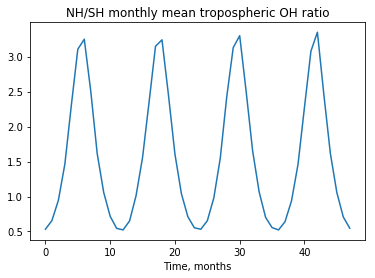

In [7]:
# Plot monthly mean ratio of OH in the Northern Hemisphere to OH in the Southern Hemisphere
plt.plot((oh_nh/oh_sh).data)
plt.title('NH/SH monthly mean tropospheric OH ratio')
plt.xlabel('Time, months');
plt.savefig(path_to_figs / f'{exp}_oh_ratio_monthly_mean_airmass_averaged_trop.png');

In [11]:
oh.coord('time').points.shape # 4 years of data

(48,)

In [9]:
# Calculate annual mean OH ratio
annual_mean_oh_nh = oh_nh.data.reshape(4,12).mean(axis=1)
annual_mean_oh_sh = oh_sh.data.reshape(4,12).mean(axis=1)

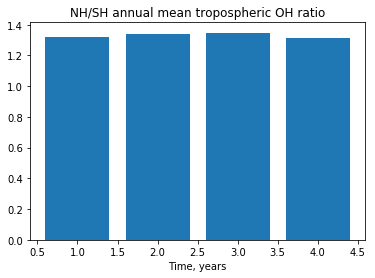

In [12]:
# Plot annual mean ratio of OH in the Northern Hemisphere to OH in the Southern Hemisphere
plt.bar(np.arange(1,5), annual_mean_oh_nh/annual_mean_oh_sh)
plt.title('NH/SH annual mean tropospheric OH ratio')
plt.xlabel('Time, years');
plt.savefig(path_to_figs / f'{exp}_oh_ratio_annual_mean_airmass_averaged_trop.png');

In [15]:
np.mean(annual_mean_oh_nh/annual_mean_oh_sh), np.std(annual_mean_oh_nh/annual_mean_oh_sh)

(1.329839662004211, 0.013386642599539)